# Explore CMIP6 data on Casper

Ensure you have the required libraries installed, these will make it much easier to work with the data

In [1]:
! pip install netcdf4 xarray[io] cartopy nc-time-axis

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import os.path

import matplotlib.pyplot as plt
# Useful for plotting maps
import cartopy.crs as ccrs

# This can be useful for working with multiple processors - to be explored later on
# from dask.distributed import Client, LocalCluster

Output data is in `/glade/collections/cmip/CMIP6/{activity}/NCC/NorESM2-LM/{experiment}`

You can also find other model data here, in particular the NCAR model:
Example path: `/glade/collections/cmip/CMIP6/DAMIP/NCAR/CESM2/hist-aer/r1i1p1f1/Amon/tas/gn/latest/*.nc`

Input data (the emissions data used to drive the experiments) is in: `/glade/p/cesmdata/cseg/inputdata/atm/cam/chem/emis/`

In [129]:
# You can explore these directly using the command line
!ls /glade/collections/cmip/CMIP6/DAMIP/NCC/NorESM2-LM/hist-GHG/r1i1p1f1/Amon  

hfls  pr   rlds  rlut  rsdt  rsut  tas	ua  wap
hfss  psl  rlus  rsds  rsus  ta    ts	va


In [50]:
# Or open them directly with xarray. E.g. to open the ssp245 scenario monthly data for precipitation from the 11th realization of the CESM2 model:
xr.open_mfdataset("/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245/r11i1p1f1/Amon/pr/gn/files/d20200528/*.nc")


SyntaxError: unterminated string literal (detected at line 2) (852518108.py, line 2)

The model names are not very obvious but you can either google them, ask ChatGPT, or look them up in these structured dictionaries: https://github.com/PCMDI/cmip6-cmor-tables/tree/main/Tables (which can be queried with e.g. Pandas)

The below utility function can help you find the activity associated with a particular experiment

In [12]:
def get_MIP(experiment):
    """
    Utility function to get the activity associated with a particular experiment
    """
    if experiment == 'ssp245-covid':
        return 'DAMIP'
    elif experiment == 'ssp370-lowNTCF':
        return 'AerChemMIP'
    elif experiment.startswith('ssp'):
        return 'ScenarioMIP'
    elif experiment.startswith('hist-'):
        return 'DAMIP'
    else:
        return 'CMIP'


In [13]:
def get_data(variable, experiment, member):
    """
    Read a particular CMIP6 (Amon) variable from NorESM2
    """
    import glob
    files = glob.glob(f"/glade/collections/cmip/CMIP6/{get_MIP(experiment)}/NCC/NorESM2-LM/{experiment}/{member}/Amon/{variable}/gn/v20190815/{variable}/*.nc")
    return xr.open_mfdataset(files)[variable]

In [7]:
# Now I can simply call this function to get the data I want for a particular variable, experiment and ensemble member
tas = get_data('tas', 'historical', 'r1i1p1f1')

In [162]:
!ls /glade/collections/cmip/CMIP6/DAMIP/NCC/NorESM2-LM/hist-GHG/r1i1p1f1/Amon  


hfls  pr   rlds  rlut  rsdt  rsut  tas	ua  wap
hfss  psl  rlus  rsds  rsus  ta    ts	va


In [8]:
tas

<xarray.DataArray 'tas' (time: 1980, lat: 96, lon: 144)> Size: 109MB
dask.array<concatenate, shape=(1980, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  TREFHT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-08-15T12:42:20Z altered by CMOR: Treated scalar dime...

*Note*, the ensemble member format: 
`r` for realization, `i` for initialization, `p` for physics, and `f` for forcing

We're only interested in different realizations in this project, so try different r numbers but keep the rest the same: E.g.: `r1i1p1f1`, `r2i1p1f1`, `r3i1p1f1`

In [9]:
# When averaging gridded data on a sphere, we need to account for the fact that the values near the poles have less area
weights = np.cos(np.deg2rad(tas.lat))
weights.name = "weights"

tas_timeseries = tas.weighted(weights).mean(['lat', 'lon'])



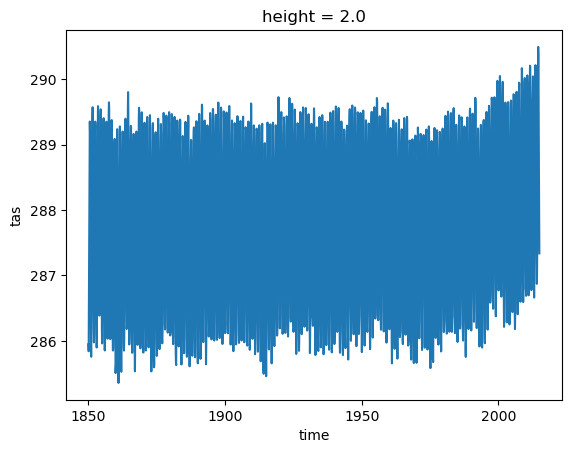

In [10]:
tas_timeseries.plot()

/glade/u/home/nchu/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


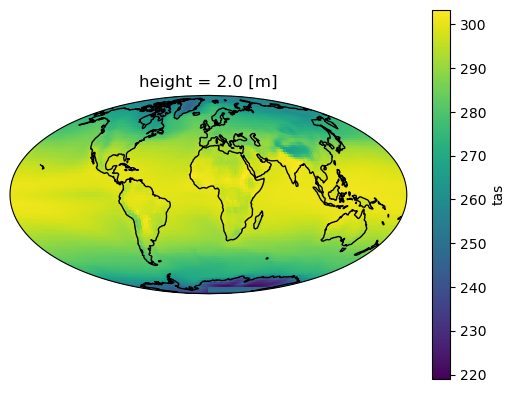

In [11]:
# Plot a map of the average temperature between 1850-1900

tas.sel(time=slice('1850','1900')).mean('time').plot(
    transform=ccrs.PlateCarree(), # This is the projection the data is stored as
    subplot_kws={"projection": ccrs.Mollweide()}, # This describes the projection to plot onto (which happens to be the projection the data is already in so no transformation is needed in this case)
)

# Feel free to explore other projections here: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

plt.gca().coastlines()


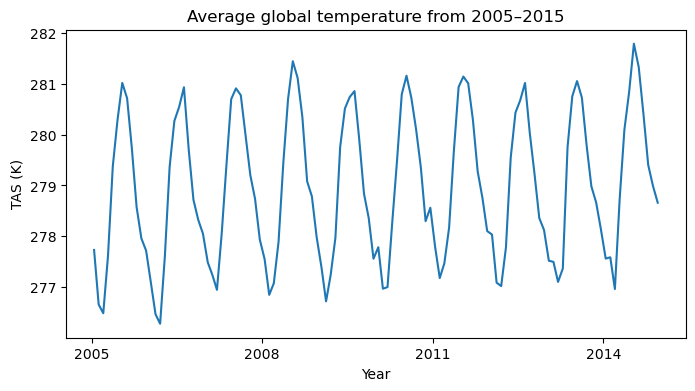

In [31]:
# Average global temperature between 2005-2015

tas_mean = tas.sel(time=slice('2005', '2015')).mean(dim=['lat', 'lon'])

fig, ax = plt.subplots(figsize=(8,4))
tas_mean.plot(ax=ax)

ax.set_title("Average global temperature from 2005–2015")
ax.set_xlabel("Year")
ax.set_ylabel(f"TAS ({tas_mean.attrs.get('units','K')})")

plt.show()

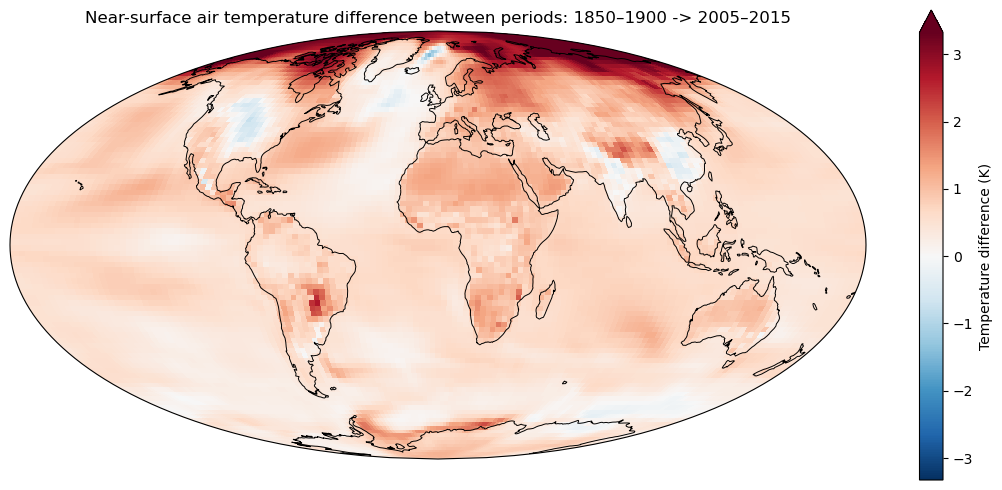

In [47]:
# Difference in mean TAS between periods 1850-1900 and 2005-2015

tas_early = tas.sel(time=slice('1850', '1900')).mean('time')     
tas_late  = tas.sel(time=slice('2005', '2015')).mean('time')      

tas_diff = tas_late - tas_early  

if float(tas_diff.lon.max()) > 180:
    tas_diff = tas_diff.assign_coords(lon=((tas_diff.lon + 180) % 360) - 180).sortby('lon')

fig, ax = plt.subplots(figsize=(11, 5), subplot_kw=dict(projection=ccrs.Mollweide()))

p = tas_diff.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),     
    cmap='RdBu_r',
    robust=True,                     
    cbar_kwargs={'label': 'Temperature difference (K)'}  
)

ax.coastlines(linewidth=0.7)
ax.set_title('Near-surface air temperature difference between periods: 1850–1900 -> 2005–2015')
plt.tight_layout()
plt.show()

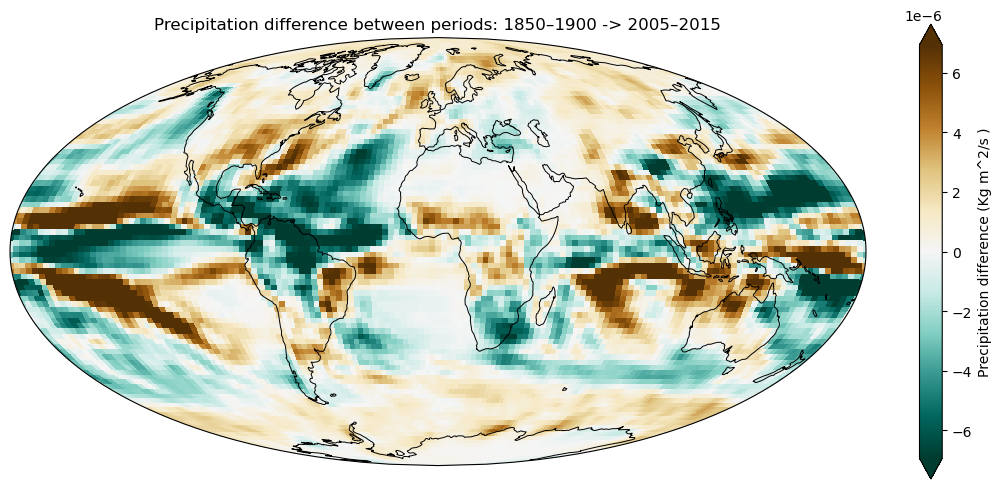

In [46]:
# Difference in precipitation between periods 1850-1900 and 2005-2015

pr = get_data('pr', 'historical', 'r1i1p1f1')

pr_early = pr.sel(time=slice('1850', '1900')).mean('time')     
pr_late  = pr.sel(time=slice('2005', '2015')).mean('time')      

pr_diff = pr_late - pr_early  

if float(pr_diff.lon.max()) > 180:
    pr_diff = pr_diff.assign_coords(lon=((pr_diff.lon + 180) % 360) - 180).sortby('lon')

fig, ax = plt.subplots(figsize=(11, 5), subplot_kw=dict(projection=ccrs.Mollweide()))

p = pr_diff.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),     
    cmap='BrBG_r',
    robust=True,                     
    cbar_kwargs={'label': 'Precipitation difference (Kg m^2/s )'}  
)

ax.coastlines(linewidth=0.7)
ax.set_title('Precipitation difference between periods: 1850–1900 -> 2005–2015')
plt.tight_layout()
plt.show()

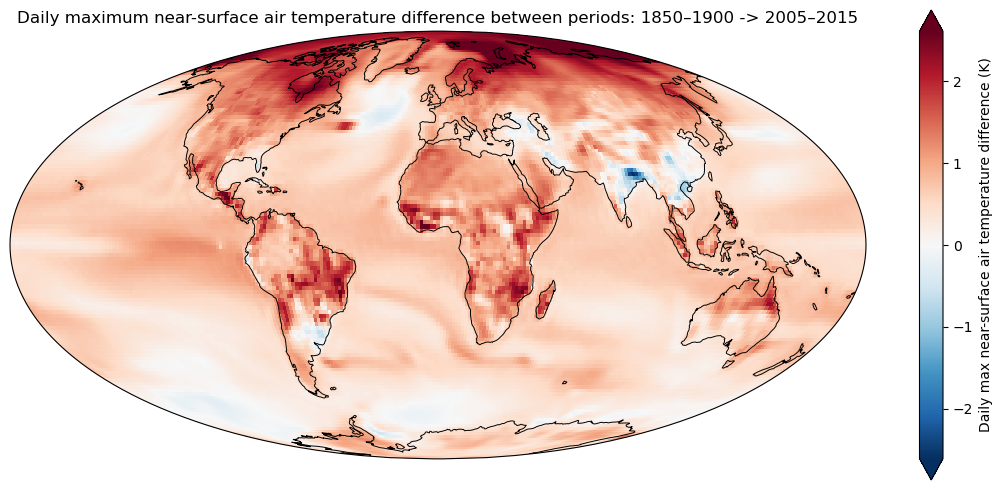

In [143]:
# Difference in max TAS between periods 1850-1900 and 2005-2015

files = glob.glob("/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/day/tasmax/gn/v20191016/*.nc")
maxtas = xr.open_mfdataset(files, combine='by_coords')['tasmax']  # <-- select variable

maxtas_early = maxtas.sel(time=slice('1850', '1900')).mean('time')
maxtas_late  = maxtas.sel(time=slice('2005', '2014')).mean('time')

maxtas_diff = maxtas_late - maxtas_early  

if float(maxtas_diff.lon.max()) > 180:
    maxtas_diff = maxtas_diff.assign_coords(lon=((maxtas_diff.lon + 180) % 360) - 180).sortby('lon')

fig, ax = plt.subplots(figsize=(11, 5), subplot_kw=dict(projection=ccrs.Mollweide()))
maxtas_diff.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    robust=True,
    cbar_kwargs={'label': 'Daily max near-surface air temperature difference (K)'}
)

ax.coastlines(linewidth=0.7)
ax.set_title('Daily maximum near-surface air temperature difference between periods: 1850–1900 -> 2005–2015')
plt.tight_layout()
plt.show()

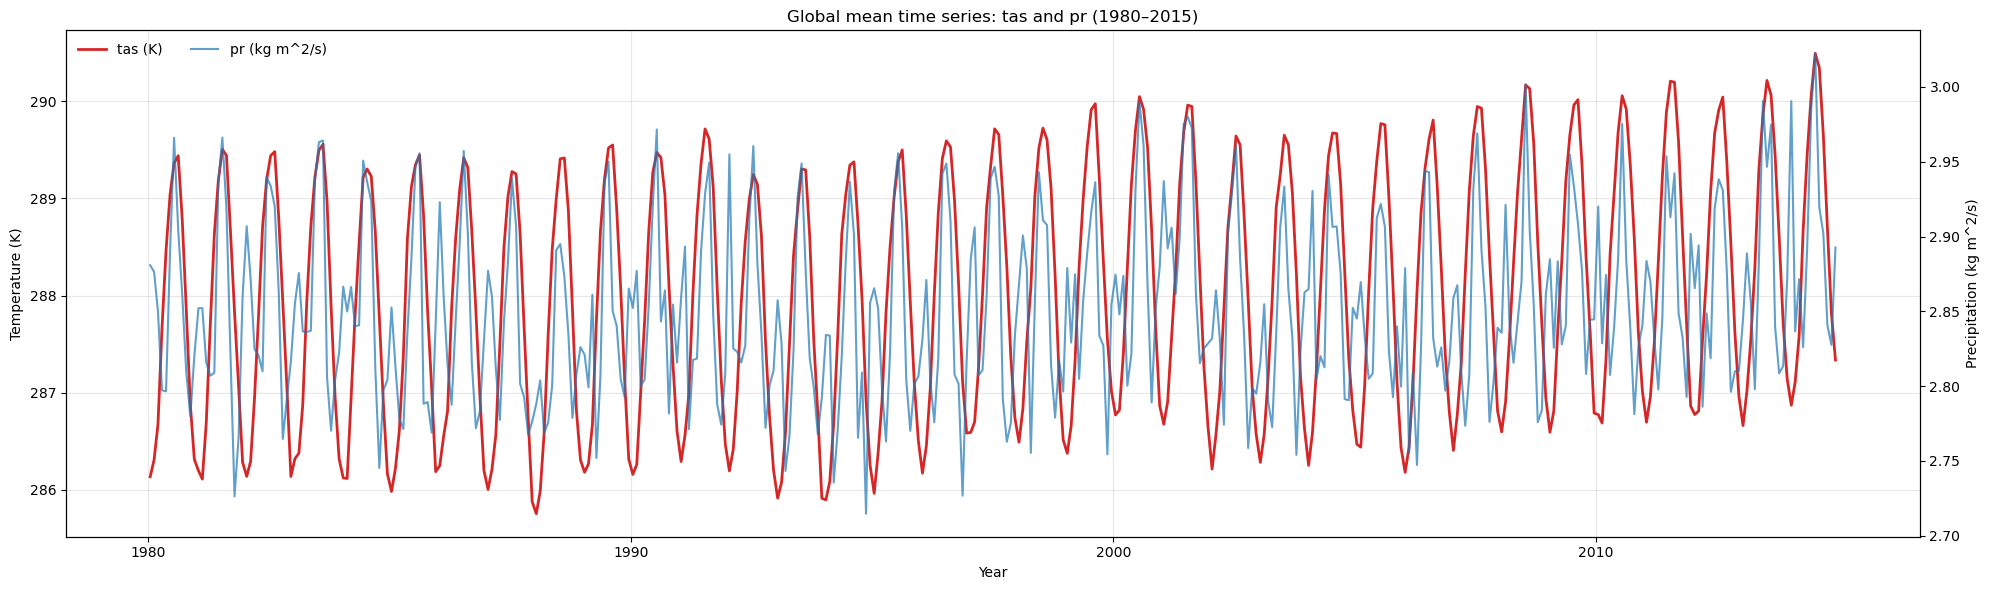

In [156]:
# Global average time-series for TAS and PR for period 1980-2015

tas = get_data('tas', 'historical', 'r1i1p1f1').sel(time=slice('1980','2015'))
pr  = (get_data('pr',  'historical', 'r1i1p1f1') * 86400).sel(time=slice('1980','2015'))

w = np.cos(np.deg2rad(tas.lat))
W = xr.DataArray(w, coords={'lat': tas.lat}, dims=['lat']).broadcast_like(tas.isel(time=0, drop=True))
W = W / W.sum(dim=('lat','lon'))

tas_g = (tas * W).sum(dim=('lat','lon'))
pr_g  = (pr  * W).sum(dim=('lat','lon'))

tas_g, pr_g = xr.align(tas_g, pr_g, join='inner')

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(tas_g['time'].values, tas_g.values, label='tas (K)', linewidth=2, color='tab:red')
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Year')

ax2 = ax.twinx()
ax2.plot(pr_g['time'].values, pr_g.values, label='pr (kg m^2/s)', linewidth=1.5, alpha=0.7)
ax2.set_ylabel('Precipitation (kg m^2/s)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, loc='upper left', frameon=False, ncol=2)

ax.set_title('Global mean time series: tas and pr (1980–2015)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


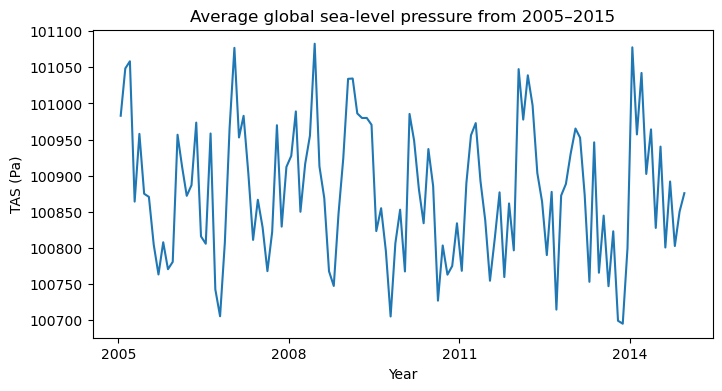

In [164]:
# Graphs for PSL

psl = get_data('psl', 'historical', 'r1i1p1f1')
psl_mean = psl.sel(time=slice('2005', '2015')).mean(dim=['lat', 'lon'])

fig, ax = plt.subplots(figsize=(8,4))
psl_mean.plot(ax=ax)

ax.set_title("Average global sea-level pressure from 2005–2015")
ax.set_xlabel("Year")
ax.set_ylabel(f"TAS ({tas_mean.attrs.get('units','Pa')})")

plt.show()

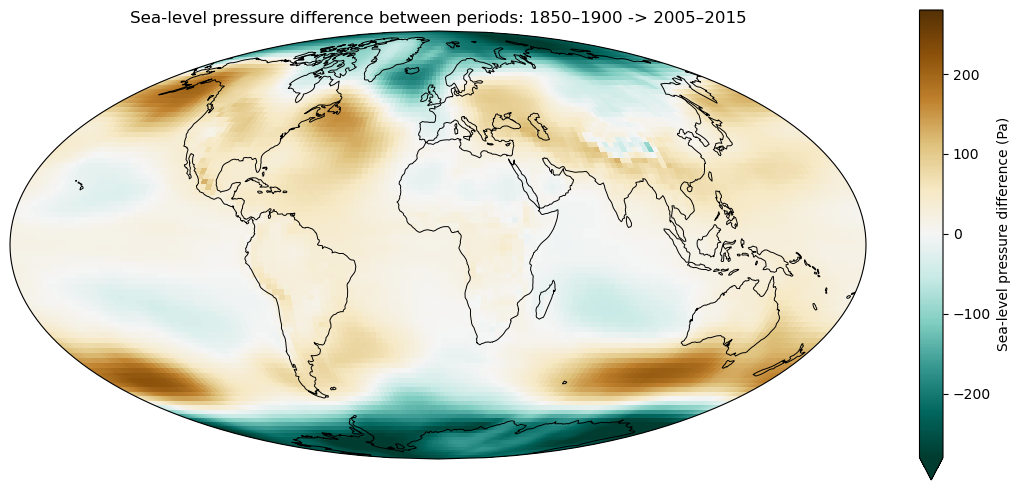

In [166]:
psl_early = psl.sel(time=slice('1850', '1900')).mean('time')     
psl_late  = psl.sel(time=slice('2005', '2015')).mean('time')      

psl_diff = psl_late - psl_early  

if float(psl_diff.lon.max()) > 180:
    psl_diff = psl_diff.assign_coords(lon=((psl_diff.lon + 180) % 360) - 180).sortby('lon')

fig, ax = plt.subplots(figsize=(11, 5), subplot_kw=dict(projection=ccrs.Mollweide()))

p = psl_diff.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),     
    cmap='BrBG_r',
    robust=True,                     
    cbar_kwargs={'label': 'Sea-level pressure difference (Pa)'}  
)

ax.coastlines(linewidth=0.7)
ax.set_title('Sea-level pressure difference between periods: 1850–1900 -> 2005–2015')
plt.tight_layout()
plt.show()